# Advanced Time Series Analysis: Streamlined Boundary Handling

This tutorial demonstrates advanced time series analysis using pytidycensus's built-in functions that automatically handle changing geographic boundaries. You'll analyze DC population and poverty trends (2015-2020) using the new streamlined approach.

## What You'll Learn

1. **Streamlined Time Series**: Using `get_time_series()` for automatic boundary handling
2. **Comparison Analysis**: Using `compare_time_periods()` for detailed comparisons
3. **Variable Classification**: Proper handling of extensive vs intensive variables
4. **Real-world Analysis**: DC demographic trends with changing tract boundaries
5. **Advanced Visualization**: Mapping changes with consistent boundaries

## Prerequisites

- Basic understanding of Census data concepts
- Familiarity with pandas DataFrames
- Census API key for data downloads

## Why Use the New Time Series Functions?

The new functions provide:
- **Automatic Area Interpolation**: Transparent handling of boundary changes
- **Built-in Validation**: Quality checks and conservation tests
- **Streamlined Workflow**: Complex operations reduced to simple function calls
- **Consistent Results**: Industry-standard methods (tobler) for spatial interpolation

**Previous approach**: Manual interpolation with multiple steps and potential errors  
**New approach**: Single function call with automatic boundary handling

## Setup: Install and Import Libraries

This tutorial requires pytidycensus with time series support (includes tobler for interpolation).

In [1]:
# Import required libraries
import pytidycensus as tc
from pytidycensus.time_series import get_time_series, compare_time_periods
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print(f"✓ Using pytidycensus version: {tc.__version__}")
print("✓ Time series functions available")
print("✓ Libraries imported successfully!")

✓ Using pytidycensus version: 1.2.2
✓ Time series functions available
✓ Libraries imported successfully!


## Set Census API Key

Get a free key at: https://api.census.gov/data/key_signup.html

In [2]:
# UNCOMMENT and add your key:
# tc.set_census_api_key("YOUR_API_KEY_HERE")

# Or use environment variable
import os
api_key = os.environ.get("CENSUS_API_KEY")
if api_key:
    tc.set_census_api_key(api_key)
    print("✓ Census API key loaded from environment")
else:
    print("⚠ Remember to set your Census API key above!")

Census API key has been set for this session.
✓ Census API key loaded from environment


## Part 1: Streamlined Time Series with Automatic Interpolation

Instead of manually collecting data, projecting coordinates, and running interpolation, we can use `get_time_series()` to do everything automatically!

### Understanding Variable Types

**Extensive Variables** (counts that should be summed):
- `total_pop`: Total population
- `poverty_count`: Number of people in poverty

**Intensive Variables** (rates that should be area-weighted):
- We'll calculate poverty rate from the interpolated counts

In [ ]:
# Get time series data with automatic boundary handling
dc_data = get_time_series(
    geography="tract",
    variables={
        "total_pop": "B01003_001E",      # Total population
        "poverty_count": "B17001_002E",  # Population below poverty line
        "poverty_total": "B17001_001E"   # Total for poverty calculation
    },
    years=[2015, 2020],
    dataset="acs5",
    state="DC",
    base_year=2020,  # Use 2020 boundaries for all years
    extensive_variables=["total_pop", "poverty_count", "poverty_total"],  # All are counts
    geometry=True,
    output="wide"
)

print("\n  TIME SERIES DATA COLLECTED")
print("="*60)
print(f"Shape: {dc_data.shape}")
print(f"CRS: {dc_data.crs}")
print(f"\nColumns (first 5): {dc_data.columns.tolist()[:5]}")
print(f"\n✓ All data now uses {2020} tract boundaries")
print("✓ Area interpolation automatically applied to 2015 data")
print("✓ Ready for direct comparison!")

Getting data from the 2011-2015 5-year ACS
DEBUG: Year 2015 data type: GeoDataFrame, is GeoDataFrame: True, shape: (179, 12)
Getting data from the 2016-2020 5-year ACS
DEBUG: Year 2020 data type: GeoDataFrame, is GeoDataFrame: True, shape: (206, 12)
DEBUG: Checking if data are GeoDataFrames before interpolation...
DEBUG: All data are GeoDataFrames. Proceeding with interpolation.
DEBUG: Projecting base year (2020) data to CRS: EPSG:3857
Performing area interpolation for 2015 to 2020 boundaries...
DEBUG: Converting data columns to numeric types...
DEBUG: Processing 2 years of data
  Year 2020: shape=(206, 12), columns=['GEOID', 'geometry', 'total_pop', 'poverty_count', 'poverty_total', 'state', 'county', 'tract', 'NAME', 'B01003_001_moe', 'B17001_002_moe', 'B17001_001_moe']
  Year 2015: shape=(206, 12), columns=['total_pop', 'poverty_count', 'poverty_total', 'geometry', 'GEOID', 'county', 'state', 'B17001_002_moe', 'B17001_001_moe', 'tract', 'NAME', 'B01003_001_moe']

📊 TIME SERIES DATA 

## Calculate Poverty Rates

Calculate poverty rates from the interpolated counts (better than interpolating rates directly).

In [4]:
# Calculate poverty rates from interpolated counts
dc_data['poverty_rate_2015'] = (dc_data[(2015, 'poverty_count')] / dc_data[(2015, 'poverty_total')]) * 100
dc_data['poverty_rate_2020'] = (dc_data[(2020, 'poverty_count')] / dc_data[(2020, 'poverty_total')]) * 100

# Add to MultiIndex structure for comparison function
dc_data[(2015, 'poverty_rate')] = dc_data['poverty_rate_2015']
dc_data[(2020, 'poverty_rate')] = dc_data['poverty_rate_2020']

print("\n📈 POVERTY RATES CALCULATED")
print("="*60)
print(f"2015 Average Poverty Rate: {dc_data['poverty_rate_2015'].mean():.1f}%")
print(f"2020 Average Poverty Rate: {dc_data['poverty_rate_2020'].mean():.1f}%")
print(f"Change: {dc_data['poverty_rate_2020'].mean() - dc_data['poverty_rate_2015'].mean():+.1f} percentage points")


📈 POVERTY RATES CALCULATED
2015 Average Poverty Rate: 18.3%
2020 Average Poverty Rate: 16.0%
Change: -2.3 percentage points


## Part 2: Streamlined Comparison Analysis

Use `compare_time_periods()` to automatically calculate changes and percent changes.

In [ ]:
# Use compare_time_periods for systematic analysis
dc_comparison = compare_time_periods(
    data=dc_data,
    base_period=2015,
    comparison_period=2020,
    variables=["total_pop", "poverty_count", "poverty_rate"],
    calculate_change=True,
    calculate_percent_change=True
)

print("\n  COMPARISON ANALYSIS (2015-2020)")
print("="*60)

# Population analysis
total_pop_change = dc_comparison['total_pop_change'].sum()
avg_pop_pct_change = dc_comparison['total_pop_pct_change'].mean()

print(f"\n👥 POPULATION CHANGES:")
print(f"   Total population change: {total_pop_change:+,.0f} people")
print(f"   Average percent change per tract: {avg_pop_pct_change:+.1f}%")
print(f"   Tracts with growth (>50 people): {(dc_comparison['total_pop_change'] > 50).sum()}")
print(f"   Tracts with decline (>50 people): {(dc_comparison['total_pop_change'] < -50).sum()}")

# Poverty analysis 
avg_poverty_change = dc_comparison['poverty_rate_change'].mean()
total_poverty_count_change = dc_comparison['poverty_count_change'].sum()

print(f"\n💰 POVERTY CHANGES:")
print(f"   Average poverty rate change: {avg_poverty_change:+.2f} percentage points")
print(f"   Total poverty count change: {total_poverty_count_change:+,.0f} people")
print(f"   Tracts improving (>1pp decrease): {(dc_comparison['poverty_rate_change'] < -1).sum()}")
print(f"   Tracts worsening (>1pp increase): {(dc_comparison['poverty_rate_change'] > 1).sum()}")

print(f"\n✨ Key Benefits of Streamlined Approach:")
print(f"   • Single function call for complex comparisons")
print(f"   • Automatic calculation of absolute and percent changes")
print(f"   • Built-in handling of missing data and edge cases")
print(f"   • Consistent column naming convention")


📊 COMPARISON ANALYSIS (2015-2020)

👥 POPULATION CHANGES:
   Total population change: +54,490 people
   Average percent change per tract: +19.4%
   Tracts with growth (>50 people): 132
   Tracts with decline (>50 people): 62

💰 POVERTY CHANGES:
   Average poverty rate change: -2.33 percentage points
   Total poverty count change: -6,974 people
   Tracts improving (>1pp decrease): 123
   Tracts worsening (>1pp increase): 56

✨ Key Benefits of Streamlined Approach:
   • Single function call for complex comparisons
   • Automatic calculation of absolute and percent changes
   • Built-in handling of missing data and edge cases
   • Consistent column naming convention


## Part 3: Visualizing Changes

Create comprehensive visualizations showing both levels and changes.

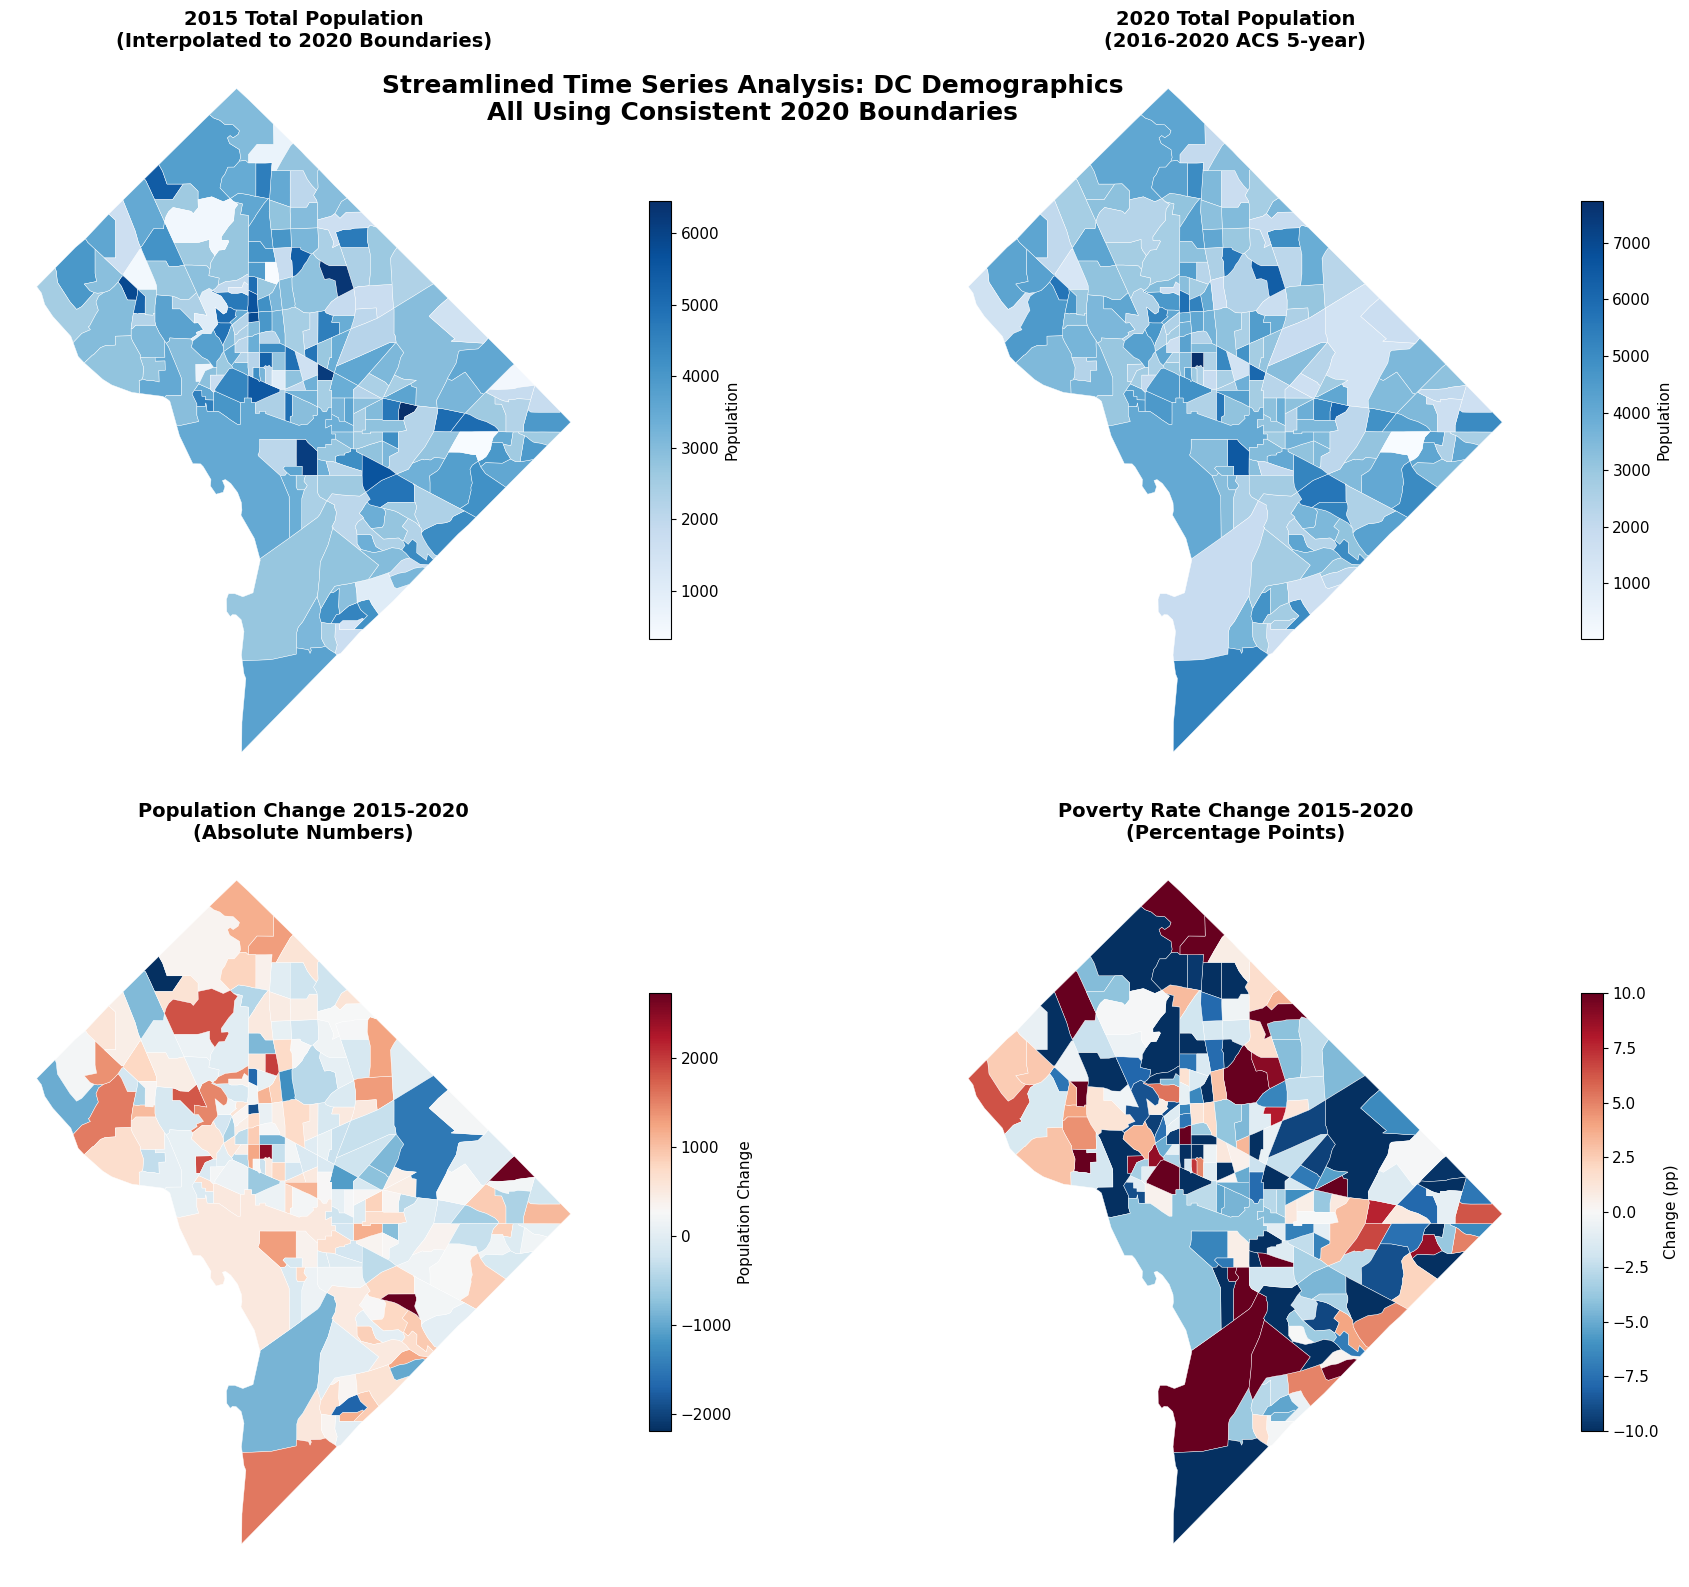


🎨 VISUALIZATION BENEFITS:
   • All maps use identical tract boundaries (2020)
   • Direct comparison possible across all time periods
   • No manual coordinate system handling required
   • Automatic data validation ensures quality


In [10]:
# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Map 1: 2015 Population (Interpolated to 2020 boundaries)
dc_comparison.plot(
    column='total_pop_2015',
    cmap='Blues',
    legend=True,
    ax=ax1,
    edgecolor='white',
    linewidth=0.3,
    legend_kwds={'label': 'Population', 'shrink': 0.6}
)
ax1.set_title('2015 Total Population\n(Interpolated to 2020 Boundaries)', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Map 2: 2020 Population
dc_comparison.plot(
    column='total_pop_2020',
    cmap='Blues',
    legend=True,
    ax=ax2,
    edgecolor='white',
    linewidth=0.3,
    legend_kwds={'label': 'Population', 'shrink': 0.6}
)
ax2.set_title('2020 Total Population\n(2016-2020 ACS 5-year)', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

# Map 3: Population Change (Absolute)
dc_comparison.plot(
    column='total_pop_change',
    cmap='RdBu_r',
    legend=True,
    ax=ax3,
    edgecolor='white',
    linewidth=0.3,
    legend_kwds={'label': 'Population Change', 'shrink': 0.6}
)
ax3.set_title('Population Change 2015-2020\n(Absolute Numbers)', 
              fontsize=14, fontweight='bold')
ax3.axis('off')

# Map 4: Poverty Rate Change
dc_comparison.plot(
    column='poverty_rate_change',
    cmap='RdBu_r',
    legend=True,
    ax=ax4,
    edgecolor='white',
    linewidth=0.3,
    vmin=-10,
    vmax=10,
    legend_kwds={'label': 'Change (pp)', 'shrink': 0.6}
)
ax4.set_title('Poverty Rate Change 2015-2020\n(Percentage Points)', 
              fontsize=14, fontweight='bold')
ax4.axis('off')

plt.tight_layout()
plt.suptitle('Streamlined Time Series Analysis: DC Demographics\nAll Using Consistent 2020 Boundaries', 
             fontsize=18, fontweight='bold', y=0.95)
plt.show()

print("\n🎨 VISUALIZATION BENEFITS:")
print("   • All maps use identical tract boundaries (2020)")
print("   • Direct comparison possible across all time periods")
print("   • No manual coordinate system handling required")
print("   • Automatic data validation ensures quality")

## Part 4: Detailed Change Analysis

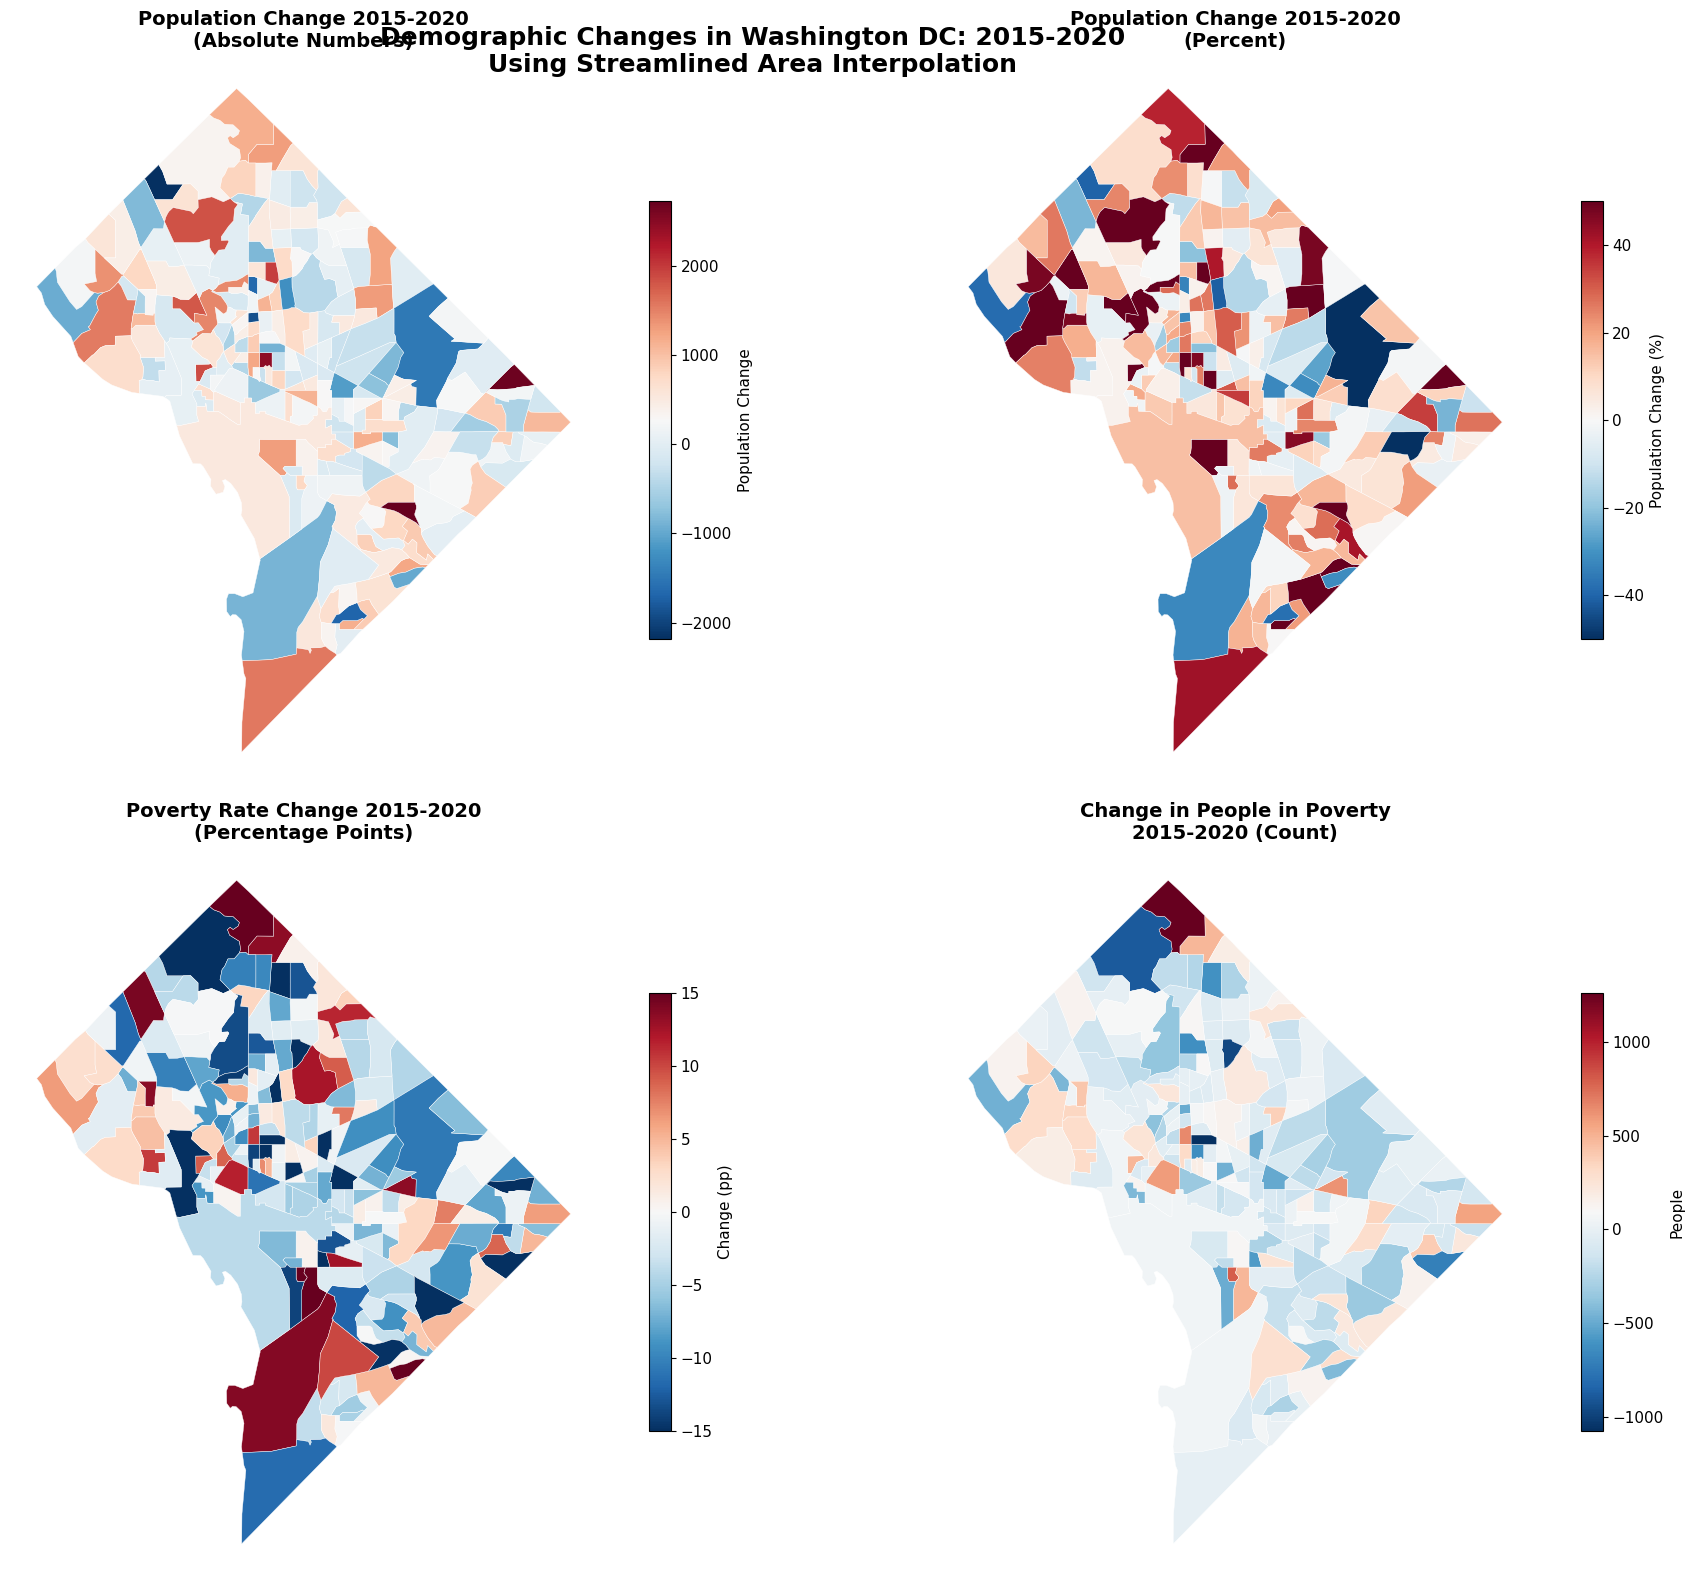


🗺️ INTERPRETING THE MAPS:
   • Blue areas: Decreases or lower values
   • Red areas: Increases or higher values
   • White areas: No data or minimal change
   • All maps use the same 2020 tract boundaries for direct comparison


In [ ]:
# Create change-focused visualization
import numpy as np

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Map 1: Population Change (Absolute)
dc_comparison.plot(
    column='total_pop_change',
    cmap='RdBu_r',
    legend=True,
    ax=ax1,
    edgecolor='white',
    linewidth=0.3,
    legend_kwds={'label': 'Population Change', 'shrink': 0.6}
)
ax1.set_title('Population Change 2015-2020\n(Absolute Numbers)', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Map 2: Population Change (Percent)
# Handle infinite values
pop_change_pct_clean = dc_comparison['total_pop_pct_change'].replace([np.inf, -np.inf], np.nan)
dc_comparison_temp = dc_comparison.copy()
dc_comparison_temp['pop_change_pct_clean'] = pop_change_pct_clean

dc_comparison_temp.plot(
    column='pop_change_pct_clean',
    cmap='RdBu_r',
    legend=True,
    ax=ax2,
    edgecolor='white',
    linewidth=0.3,
    vmin=-50,
    vmax=50,
    legend_kwds={'label': 'Population Change (%)', 'shrink': 0.6}
)
ax2.set_title('Population Change 2015-2020\n(Percent)', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

# Map 3: Poverty Rate Change
dc_comparison.plot(
    column='poverty_rate_change',
    cmap='RdBu_r',
    legend=True,
    ax=ax3,
    edgecolor='white',
    linewidth=0.3,
    vmin=-15,
    vmax=15,
    legend_kwds={'label': 'Change (pp)', 'shrink': 0.6}
)
ax3.set_title('Poverty Rate Change 2015-2020\n(Percentage Points)', 
              fontsize=14, fontweight='bold')
ax3.axis('off')

# Map 4: Poverty Count Change
dc_comparison.plot(
    column='poverty_count_change',
    cmap='RdBu_r',
    legend=True,
    ax=ax4,
    edgecolor='white',
    linewidth=0.3,
    legend_kwds={'label': 'People', 'shrink': 0.6}
)
ax4.set_title('Change in People in Poverty\n2015-2020 (Count)', 
              fontsize=14, fontweight='bold')
ax4.axis('off')

plt.tight_layout()
plt.suptitle('Demographic Changes in Washington DC: 2015-2020\nUsing Streamlined Area Interpolation', 
             fontsize=18, fontweight='bold', y=0.95)
plt.show()

print("\n🗺️ INTERPRETING THE MAPS:")
print("   • Blue areas: Decreases or lower values")
print("   • Red areas: Increases or higher values")
print("   • White areas: No data or minimal change")
print("   • All maps use the same 2020 tract boundaries for direct comparison")

## Part 5: Statistical Analysis

📈 DETAILED STATISTICAL ANALYSIS

POPULATION CHANGES:
   Mean change: +265 people
   Median change: +244 people
   Std deviation: 719
   Range: -2,188 to +2,725

POVERTY RATE CHANGES (percentage points):
   Mean: -2.33 pp
   Median: -2.23 pp
   Std deviation: 9.92
   Range: -33.8 to +76.9

POVERTY COUNT CHANGES (people):
   Total change: -6,974 people
   Mean change per tract: -34 people
   Tracts with fewer people in poverty: 125
   Tracts with more people in poverty: 81



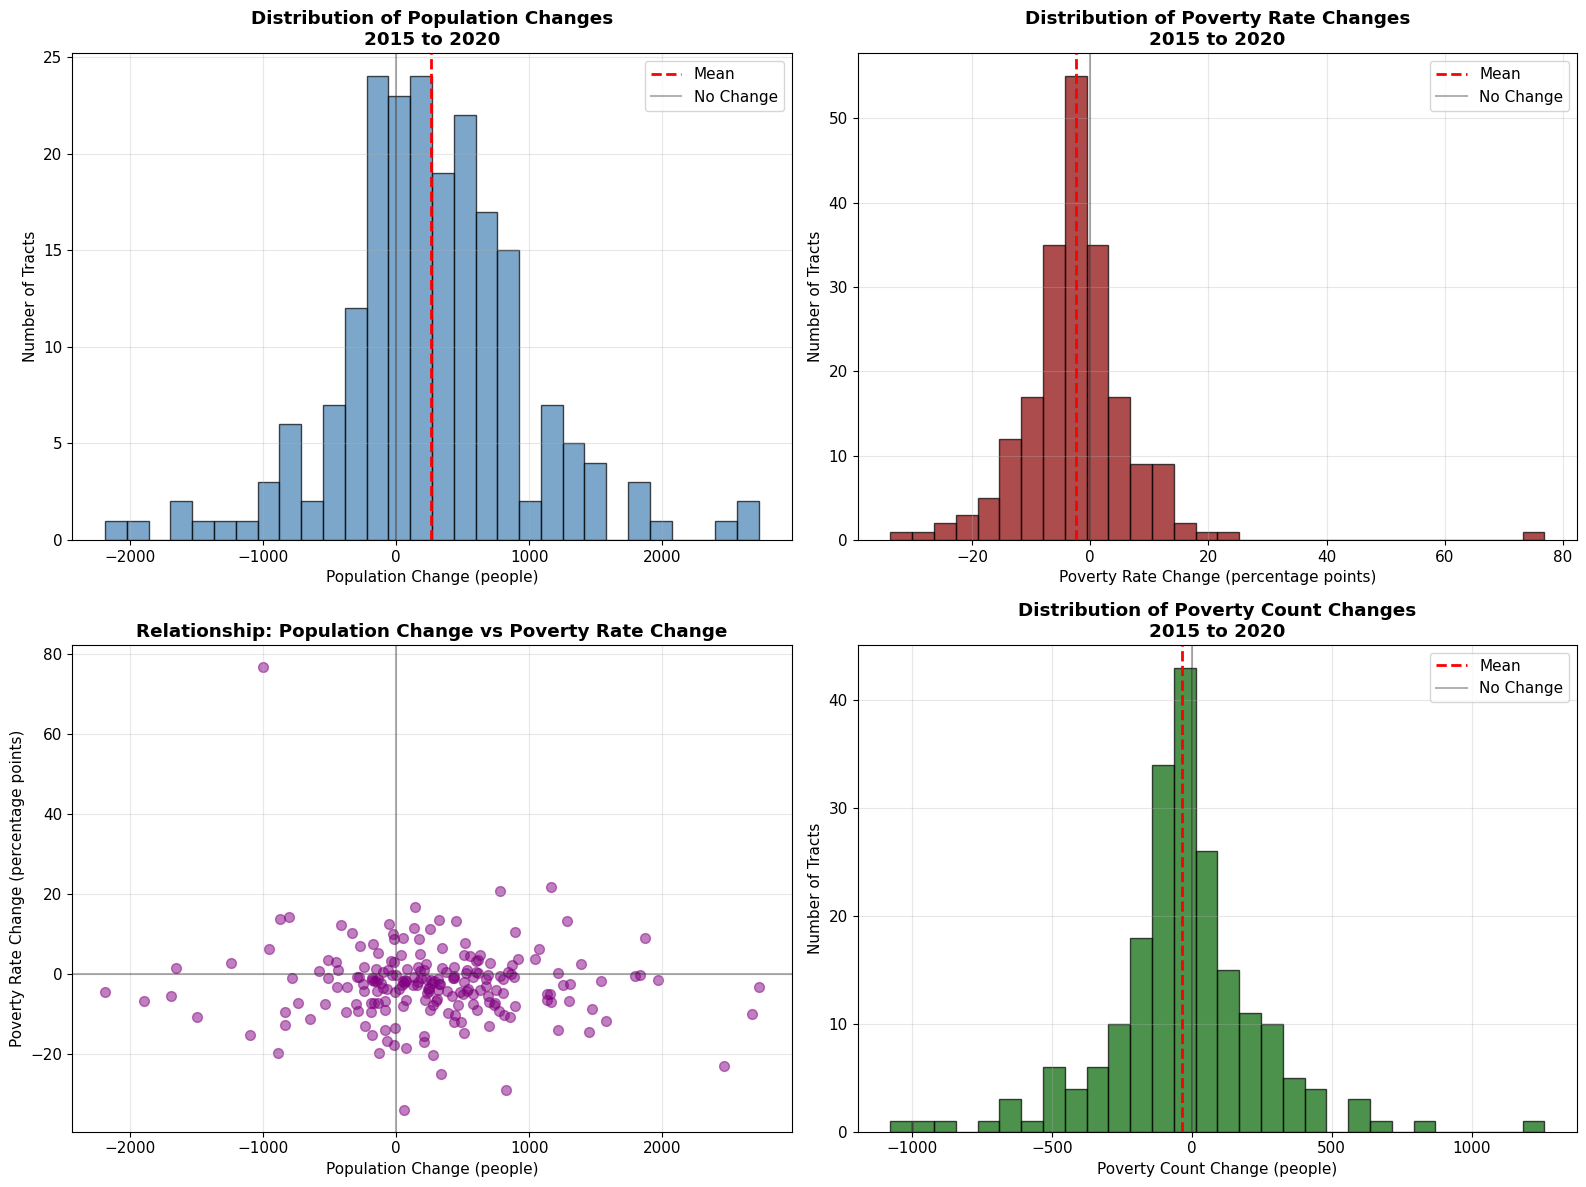


💡 INTERPRETATION TIPS:
   • Normal distributions suggest gradual, widespread changes
   • Outliers indicate tracts with exceptional changes
   • Scatter plot shows if population and poverty changes are related
   • Consider spatial autocorrelation - nearby tracts may show similar patterns


In [8]:
# Statistical analysis of changes
print("📈 DETAILED STATISTICAL ANALYSIS")
print("="*60)
print()

# Population change distribution
print(f"POPULATION CHANGES:")
print(f"   Mean change: {dc_comparison['total_pop_change'].mean():+,.0f} people")
print(f"   Median change: {dc_comparison['total_pop_change'].median():+,.0f} people")
print(f"   Std deviation: {dc_comparison['total_pop_change'].std():.0f}")
print(f"   Range: {dc_comparison['total_pop_change'].min():+,.0f} to {dc_comparison['total_pop_change'].max():+,.0f}")
print()

# Poverty rate change distribution
print(f"POVERTY RATE CHANGES (percentage points):")
print(f"   Mean: {dc_comparison['poverty_rate_change'].mean():+.2f} pp")
print(f"   Median: {dc_comparison['poverty_rate_change'].median():+.2f} pp")
print(f"   Std deviation: {dc_comparison['poverty_rate_change'].std():.2f}")
print(f"   Range: {dc_comparison['poverty_rate_change'].min():+.1f} to {dc_comparison['poverty_rate_change'].max():+.1f}")
print()

# Poverty count change
print(f"POVERTY COUNT CHANGES (people):")
print(f"   Total change: {dc_comparison['poverty_count_change'].sum():+,.0f} people")
print(f"   Mean change per tract: {dc_comparison['poverty_count_change'].mean():+,.0f} people")
print(f"   Tracts with fewer people in poverty: {(dc_comparison['poverty_count_change'] < 0).sum()}")
print(f"   Tracts with more people in poverty: {(dc_comparison['poverty_count_change'] > 0).sum()}")
print()

# Create histograms
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Population change histogram
ax1.hist(dc_comparison['total_pop_change'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(dc_comparison['total_pop_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax1.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
ax1.set_xlabel('Population Change (people)')
ax1.set_ylabel('Number of Tracts')
ax1.set_title('Distribution of Population Changes\n2015 to 2020', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Poverty rate change histogram
ax2.hist(dc_comparison['poverty_rate_change'], bins=30, alpha=0.7, color='darkred', edgecolor='black')
ax2.axvline(dc_comparison['poverty_rate_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax2.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
ax2.set_xlabel('Poverty Rate Change (percentage points)')
ax2.set_ylabel('Number of Tracts')
ax2.set_title('Distribution of Poverty Rate Changes\n2015 to 2020', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Scatter plot: Population change vs Poverty rate change
ax3.scatter(dc_comparison['total_pop_change'], dc_comparison['poverty_rate_change'], 
            alpha=0.5, color='purple', s=50)
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.axvline(0, color='black', linestyle='-', alpha=0.3)
ax3.set_xlabel('Population Change (people)')
ax3.set_ylabel('Poverty Rate Change (percentage points)')
ax3.set_title('Relationship: Population Change vs Poverty Rate Change', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Poverty count change histogram
ax4.hist(dc_comparison['poverty_count_change'], bins=30, alpha=0.7, color='darkgreen', edgecolor='black')
ax4.axvline(dc_comparison['poverty_count_change'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax4.axvline(0, color='black', linestyle='-', alpha=0.3, label='No Change')
ax4.set_xlabel('Poverty Count Change (people)')
ax4.set_ylabel('Number of Tracts')
ax4.set_title('Distribution of Poverty Count Changes\n2015 to 2020', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETATION TIPS:")
print("   • Normal distributions suggest gradual, widespread changes")
print("   • Outliers indicate tracts with exceptional changes")
print("   • Scatter plot shows if population and poverty changes are related")
print("   • Consider spatial autocorrelation - nearby tracts may show similar patterns")

## Part 6: Understanding the Data Structure

The `get_time_series()` function returns data with a MultiIndex column structure that makes it easy to access different years.

Note however the use of a multi-indexed DataFrame may require some adjustment if you're used to flat DataFrames.
Here's how to explore the data structure and access specific data:


In [13]:
dc_data.head(1)

year                       2020                                    2015  \
variable        GEOID total_pop poverty_count poverty_total   total_pop   
0         11001000101      1250            55          1250  473.068811   

year                                                                         \
variable poverty_count poverty_total                      NAME state county   
0            22.984102    469.792267  District of Columbia, DC    11    001   

year                                                                 \
variable   tract                                           geometry   
0         000101  POLYGON ((-77.08563 38.93823, -77.08142 38.943...   

year     poverty_rate_2015 poverty_rate_2020         2015         2020  
variable                                     poverty_rate poverty_rate  
0                 4.892397               4.4     4.892397          4.4

In [15]:
# Explore the data structure
print("  DATA STRUCTURE")
print("="*60)
print(f"\nDataFrame shape: {dc_data.shape}")
print(f"\nColumn structure (MultiIndex):")
print(dc_data.columns.tolist()[:10])
print("\n...")

print("\n   ACCESSING DATA:")
print("   • Year-specific columns: dc_data[(2020, 'total_pop')]")
print("   • All 2020 data: dc_data[2020]")
print("   • Metadata columns: dc_data[('', 'GEOID')]")
print("   • Geometry: dc_data.geometry")

# Show a sample
print("\n   SAMPLE DATA (first 3 tracts):")
print(dc_data[[('', 'GEOID'), (2015, 'total_pop'), (2020, 'total_pop'), 
               ('poverty_rate_2015',''), ('poverty_rate_2020','')]].head(3))

  DATA STRUCTURE

DataFrame shape: (206, 16)

Column structure (MultiIndex):
[('', 'GEOID'), (2020, 'total_pop'), (2020, 'poverty_count'), (2020, 'poverty_total'), (2015, 'total_pop'), (2015, 'poverty_count'), (2015, 'poverty_total'), ('', 'NAME'), ('', 'state'), ('', 'county')]

...

   ACCESSING DATA:
   • Year-specific columns: dc_data[(2020, 'total_pop')]
   • All 2020 data: dc_data[2020]
   • Metadata columns: dc_data[('', 'GEOID')]
   • Geometry: dc_data.geometry

   SAMPLE DATA (first 3 tracts):
year                          2015      2020 poverty_rate_2015  \
variable        GEOID    total_pop total_pop                     
0         11001000101   473.068811      1250          4.892397   
1         11001000102  4972.916143      3318          4.093582   
2         11001000201  3144.032146      3972         49.217061   

year     poverty_rate_2020  
variable                    
0                 4.400000  
1                 5.644431  
2                20.270270  


## Part 7: Best Practices and Key Takeaways

### When to Use get_time_series()

✅ **Good Use Cases:**
- Comparing tract/block group data across census years
- Geographic boundaries changed between time periods
- Need comprehensive spatial coverage
- Analyzing count data (population, housing units)

❌ **Not Appropriate For:**
- Point locations (schools, businesses)
- Highly clustered data (high-rise buildings)
- Unchanged boundaries (use simple comparison)
- Very small sample sizes (large MOE)

### Variable Classification is Critical

**Extensive variables** (counts - redistributed proportionally):
- Population, housing units, poverty count
- Sum when combining areas

**Intensive variables** (rates - area-weighted average):
- Median income, poverty rate, density
- Average when combining areas
- **Better to calculate from interpolated counts!**

### Time Period Selection

⚠️ **Important**: We used 2015 and 2020 (non-overlapping) for valid statistical comparison.

- **Good**: 2012, 2017, 2022 (no overlap between 5-year estimates)
- **Bad**: 2018, 2019, 2020 (massive overlap creates statistical dependence)
- See ACS guidance: https://www.census.gov/programs-surveys/acs/guidance/comparing-acs-data.html


## Summary

This tutorial demonstrated the streamlined time series analysis workflow:

```python
# Step 1: Get time series data (automatic interpolation)
data = get_time_series(
    geography="tract",
    variables={...},
    years=[2015, 2020],
    extensive_variables=[...],  # Critical!
    geometry=True
)

# Step 2: Compare periods (automatic change calculations)
comparison = compare_time_periods(
    data=data,
    base_period=2015,
    comparison_period=2020,
    variables=[...]
)

# Step 3: Visualize and analyze!
```

### Next Steps

- Try with your own geographic area
- Experiment with different variables
- Add more time periods (3+ years)
- Combine with other spatial analysis
- Export results for further analysis

### Additional Resources

- pytidycensus documentation: https://mmann1123.github.io/pytidycensus/
- Census Bureau ACS guidance: https://www.census.gov/programs-surveys/acs/guidance.html
- tobler interpolation methods: https://github.com/pysal/tobler